In [0]:
!git clone https://github.com/bdehaine/VGN.git
print('done...')

fatal: destination path 'VGN' already exists and is not an empty directory.
done...


In [0]:
# install dependencies
!pip3 install sknw
!pip install dgl-cu101 

In [0]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F
from copy import deepcopy, copy

from numba.errors import NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaWarning)


import matplotlib.pyplot as plt
import json 
import time
import sys

import numpy as np
from PIL import Image

import os
import datetime
%matplotlib inline

import networkx as nx
import sknw
import dgl
from dgl import DGLGraph, batch
from dgl.nn.pytorch.conv import GATConv, GraphConv
import progressbar

from sklearn.metrics import f1_score
from scipy.spatial.distance import dice

# Fetching the dataset

In [0]:

def is_valid_file(path):
    if path[-4:] in ['.gif','.tif']:
        return True
    return False

def loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        if path[-4:] =='.gif':
            return img.convert('1')
        return img.convert('RGB')

def normalize(img):
    
    if img.mode=='RGB':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
        img = normalize(img)
    return img

def target_transform(class_id):
    id_to_label = {0:'label',1:'input',2:'mask'}
    return id_to_label[class_id]



class DriveDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Parameters
    ----------
    root : str
        Path of the folder with all the images.

    mode : {'train' or 'test'} (default = 'train')
        Part of the dataset that is loaded. Use 'train' to get the training set
        and 'test' to get the test set.

    """
    def __init__(self, root, mode='train'): 

        self.root = root
        dataset = self.preprocess_image(root)
         
        inputs = [t[0] for t in dataset if t[1]=='input']
        masks = [t[0] for t in dataset if t[1]=='mask']
        labels = [t[0] for t in dataset if t[1]=='label']
        
        n = int(0.8 * len(inputs))
        
        if mode == 'train':   
            
            self.inputs = inputs[:n]
            self.masks = masks[:n]
            self.labels = labels[:n]

        elif mode == 'test':

            self.inputs = inputs[n:]
            self.masks = masks[n:]
            self.labels = labels[n:]



    # preprocess images 
    @staticmethod
    def preprocess_image(root):

        dataset = datasets.ImageFolder(root, transforms.Compose([
                transforms.Resize(512),# resize the image to 512x512
                transforms.CenterCrop(512),
                transforms.ToTensor(), # convert numpy.array to tensor
                normalize]),
                is_valid_file=is_valid_file,
                loader=loader,
                target_transform=target_transform) 
        return (dataset)
    
    def __getitem__(self, index):
        
        t1 = self.inputs[index]
        t2 = self.masks[index]
        t3 = self.labels[index]
            
        return {"input": t1, "mask": t2, "label":t3 }

    def __len__(self):

        return len(self.inputs)

    

In [0]:
# The images should be in a *sub*-folder of "data/" and *not* directly in "data/"!
# otherwise the function won't find them
dir_path = "VGN/data/training/"
dataset = DriveDataset.preprocess_image(dir_path)

print(dataset[1])


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'label')


index image:  9


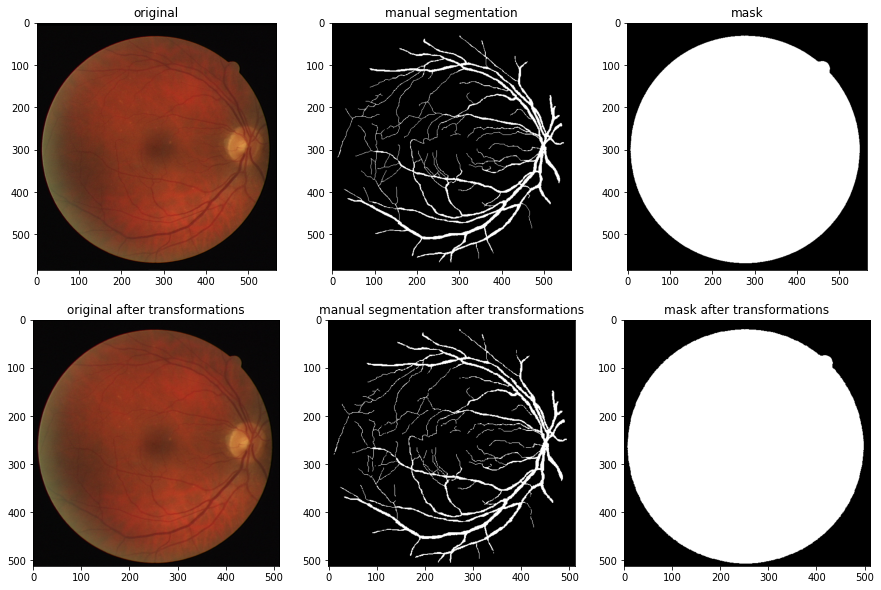

In [0]:
# show the orignal image, the manual segmentation, and mask
N_images = 20 # number of images in training set
index = np.random.randint(N_images)
print('index image: ',index)

fig, axes = plt.subplots(2, 3, figsize =(15,10))
subtitles = ['manual segmentation', 'original', 'mask']
for i in range(3):
    axes[0,(-i+1)%3].imshow(Image.open(dataset.imgs[index+20*i][0]).convert('RGB'))
    axes[0,(-i+1)%3].set_title(subtitles[i])

#show the modified images 
trans = transforms.ToPILImage()
for i in range(3):
    axes[1,(-i+1)%3].imshow(trans(dataset[index+20*i][0]).convert('RGB'))
    axes[1,(-i+1)%3].set_title(subtitles[i]+" after transformations")



# **Model**

In [0]:

class MiniUnetDown(nn.Module):
    def __init__(self, in_size, out_size,drop):
        super(MiniUnetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop)
        )
        

    def forward(self, x):
        x = self.model(x)
        return x



class MiniUnetUp(nn.Module):
    def __init__(self, in_size, out_size,drop,activation=nn.ReLU):
        super(MiniUnetUp, self).__init__()
        self.ct = nn.ConvTranspose2d(in_size, out_size, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            activation()
        )
        
    def forward(self, x, y):
        x = self.model(torch.cat((self.ct(x), y), axis=1))
        return x



##############################
#      Mini U-NET
##############################

class MiniUNet(nn.Module):
    def __init__(self,drop):
        super(MiniUNet, self).__init__()
   
        self.d3 = MiniUnetDown(32, 32,drop)
        self.d2 = MiniUnetDown(32, 64,drop)
        self.d1 = MiniUnetDown(64, 128,drop)
    
        self.u1 = MiniUnetUp(128, 64,drop)
        self.u2 = MiniUnetUp(64, 32,drop)

        self.a_layers = []


    def forward(self, x):

        d3 = self.d3(x)
        a = d3 #Layer to reuse in next Mini Unet
        self.a_layers.append(a)
        d3 = torch.cat(self.a_layers, axis=1)
        d3 = nn.Conv2d(32 * len(self.a_layers), 32, kernel_size=1, stride=1, padding=0).cuda()(d3)

        d2 = self.d2(nn.MaxPool2d(2)(d3))
        d1 = self.d1(nn.MaxPool2d(2)(d2))

        u1 = self.u1(d1,d2)
        u2 = self.u2(u1, d3)

        return u2


    def add_a(self,a_layers):
        self.a_layers = a_layers
        return None


    def get_a(self):
        return self.a_layers



In [0]:
# Below are modules implemented to define the Iter-net model more easily.

class IterNetDown(nn.Module):
    def __init__(self, in_size, out_size, drop):
        super(IterNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop)
          )

    def forward(self, x):
        return self.model(x)


class IterNetUp(nn.Module):
    def __init__(self, in_size, out_size,drop,activation=nn.ReLU):
        super(IterNetUp, self).__init__()
        self.ct = nn.ConvTranspose2d(in_size, out_size, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(out_size),
            activation()
        )
        
    def forward(self, x, y):
        x = self.model(torch.cat((self.ct(x), y), axis=1))
        return x



class Final(nn.Module):
    def __init__(self, in_size, out_size):
        super(Final, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x



##############################
#      Iter-NET
##############################

class IterNet(nn.Module):
    def __init__(self,drop,iterations=0):
        super(IterNet, self).__init__()

        self.cuda_bool = True if torch.cuda.is_available() else False

        # Nb of Mini UNets iterations
        self.iterations = iterations

        ### --------
        # Main U-net
        self.d5 = IterNetDown(3, 32,drop)
        self.d4 = IterNetDown(32, 64,drop)
        self.d3 = IterNetDown(64, 128,drop)
        self.d2 = IterNetDown(128, 256,drop)
        self.d1 = IterNetDown(256, 512,drop)

        self.u1 = IterNetUp(512, 256,drop)
        self.u2 = IterNetUp(256, 128,drop)
        self.u3 = IterNetUp(128, 64,drop)
        self.u4 = IterNetUp(64, 32,drop)
        ### --------

        self.final = Final(32, 1)


        ### ----------
        # Mini U-Net 1
        self.md3 = MiniUnetDown(32, 32,drop)
        self.md2 = MiniUnetDown(32, 64,drop)
        self.md1 = MiniUnetDown(64, 128,drop)
    
        self.mu1 = MiniUnetUp(128, 64,drop)
        self.mu2 = MiniUnetUp(64, 32,drop)


        ### ----------
        # Mini U-Net 2
        self.m2d3 = MiniUnetDown(32, 32,drop)
        self.m2d2 = MiniUnetDown(32, 64,drop)
        self.m2d1 = MiniUnetDown(64, 128,drop)
    
        self.m2u1 = MiniUnetUp(128, 64,drop)
        self.m2u2 = MiniUnetUp(64, 32,drop)

        self.a_layers = []



    def forward(self, x):
        ### --------
        # Main U-net
        d5 = self.d5(x)
        d4 = self.d4(nn.MaxPool2d(2)(d5))
        d3 = self.d3(nn.MaxPool2d(2)(d4))
        d2 = self.d2(nn.MaxPool2d(2)(d3))
        d1 = self.d1(nn.MaxPool2d(2)(d2))

        u1 = self.u1(d1,d2)
        u2 = self.u2(u1, d3)
        u3 = self.u3(u2, d4)
        u4 = self.u4(u3, d5)
        ### --------


        ### ---------
        # Mini U-Nets

        ### Iteration 1 

        if self.iterations >= 1:
            # Stores the first layer of each (Mini/)UNet
            # and uses it at the beginning of each Mini UNet
            self.a_layers = [d5]

            md3 = self.md3(u4)
            #Layer to reuse in next Mini Unet
            self.a_layers.append(md3)
            md3 = torch.cat(self.a_layers, axis=1)
            if self.cuda_bool:
                md3 = nn.Conv2d(32 * len(self.a_layers), 32, kernel_size=1, stride=1, padding=0).cuda()(md3)
            else:
                md3 = nn.Conv2d(32 * len(self.a_layers), 32, kernel_size=1, stride=1, padding=0)(md3)

            md2 = self.md2(nn.MaxPool2d(2)(md3))
            md1 = self.md1(nn.MaxPool2d(2)(md2))

            mu1 = self.mu1(md1,md2)
            mu2 = self.mu2(mu1, md3)


        ### Iteration 2

        if self.iterations >= 2:

            m2d3 = self.m2d3(mu2)
            #Layer to reuse in next Mini Unet
            self.a_layers.append(m2d3)
            m2d3 = torch.cat(self.a_layers, axis=1)

            if self.cuda_bool:
                m2d3 = nn.Conv2d(32 * len(self.a_layers), 32, kernel_size=1, stride=1, padding=0).cuda()(m2d3)
            else:
                m2d3 = nn.Conv2d(32 * len(self.a_layers), 32, kernel_size=1, stride=1, padding=0)(m2d3)

            m2d2 = self.m2d2(nn.MaxPool2d(2)(m2d3))
            m2d1 = self.m2d1(nn.MaxPool2d(2)(m2d2))

            m2u1 = self.m2u1(m2d1,m2d2)
            m2u2 = self.m2u2(m2u1, m2d3)

        if self.iterations == 1:
            final = self.final(mu2)
        elif self.iterations == 2:
            final = self.final(m2u2)
        else:
            final = self.final(u4)

        return final

In [0]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if cuda else "cpu")
print("cuda %s"%(cuda))  # check if GPU is used 

cuda True


In [0]:
# Summary of the generator 
# G = UNet().cuda()
# summary(G, (3, 512, 512) )

# Summary of the generator 
# G = IterNet(drop=0.1,iterations=1).to(device)
# summary(G, (3, 512, 512) )



# **Training our model**

In [0]:
def train(train_loader, test_loader, num_epoch=500,
          lr=0.0001, patiente=5, dropout_rate=0.1, iters_unet=2):
    """
    Method used to train our CNN model
    
    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the training dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers

    Returns:
        Classifier: (nn.Module) the trained U-net 
    """

    # Output folder 
    if not os.path.exists("VGN/models"):
        os.makedirs("VGN/models")
    if not os.path.exists("VGN/models/CNN-pretrained"):
         os.makedirs("VGN/models/CNN-pretrained")
     
    # Loss function
    criterion_CNN = torch.nn.BCEWithLogitsLoss() # A loss adapted to binary classification like torch.nn.BCEWithLogitsLoss
   
    # Initialize our model
    CNN = IterNet(drop = dropout_rate, iterations = iters_unet).to(device)
   
    # Optimizers
    optimizer_CNN = torch.optim.Adam(CNN.parameters(), lr=lr)

    # Parameters for the LR of Adam optimizer
    scheduler = lr_scheduler.StepLR(optimizer_CNN,step_size=1,gamma=0.95)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()
    best_model = deepcopy(CNN)
    test_best_loss = np.inf
    patiente_count = 0
    
    for epoch in range(num_epoch):
        
        epoch_train_loss = []
        epoch_test_loss = []

        for loader in [train_loader, test_loader]:
            
            for i, batch in enumerate(loader):
                
                # Inputs & masks & labels
                mask = batch['mask'].to(device)
                input = batch['input'].to(device)
                label = batch['label'].to(device)  
                
                # ------------------
                #  Train CNN
                # ------------------
                
                output = CNN(input) * mask
                loss_CNN = criterion_CNN(output,label)

                if loader == train_loader:
        
                    loss_CNN.backward()
                    optimizer_CNN.step()
                    optimizer_CNN.zero_grad()

                    epoch_train_loss.append(loss_CNN.item())
                
                # ------------------
                #  evaluate CNN on test data
                # ------------------
                
                elif loader == test_loader:
                    epoch_test_loss.append(loss_CNN.item())
        
        if not np.mean(epoch_test_loss) < test_best_loss - 1e-3:
                patiente_count += 1

        else:
            patiente_count = 0
            test_best_loss = np.mean(epoch_test_loss)
            best_model = copy(CNN)
            torch.save(best_model.state_dict(), 'VGN/models/CNN-pretrained/CNN.pt')

        if patiente_count >= patiente:
            
            sys.stdout.write('\ntest loss did not decrease for %d consecutive epochs' % (patiente))
            break
    
        # --------------
        #  Log Progress
        # --------------
        
        # Determine approximate time left
        
        epochs_left = num_epoch - epoch + 1
        time_left = datetime.timedelta(seconds=epochs_left * (time.time() - prev_time))
        prev_time = time.time()
                        
        
        sys.stdout.write(
            "\r[Epoch %d/%d]  [train loss: %f] [test loss: %f] ETA: %s"
            % (
                epoch,
                num_epoch,
                np.mean(epoch_train_loss),
                np.mean(epoch_test_loss),
                time_left
            )
        )

        # Decreases the learning rate
        scheduler.step()            
                        
        # Save model at the end of each epoch
        torch.save(CNN.state_dict(), 'VGN/models/CNN-pretrained/CNN-epoch-%s.pt' % epoch)

    

    return best_model

In [0]:
root = 'VGN/data/training/'

# LR will decrease with a scheduler
start_lr = 0.001

# Nb of iterations of the Mini-UNets ater the main UNet in Iter-Net
iters_unet = 1

# Create dataloaders
batch_size = 1

train_loader = DataLoader(DriveDataset(root, mode='train'),
                          batch_size=batch_size,
                          shuffle=True)


test_loader = DataLoader(DriveDataset(root, mode='test'),
                         batch_size=5,
                         shuffle=False)



start = time.time()
CNN = train(train_loader, test_loader,
                num_epoch=100, 
                iters_unet=iters_unet, 
                lr=start_lr,
                patiente=10,
                dropout_rate=0.1)

print('Time taken:',time.time()-start,'sec')

[Epoch 60/100]  [train loss: 0.294828] [test loss: 0.292954] ETA: 0:01:32.184360
test loss did not decrease for 10 consecutive epochsTime taken: 143.69548082351685 sec


# Vizualization of our trained CNN on test set


Training set, F1 score :  0.791370417928142
Validation set, F1 score :  0.7964853778375454


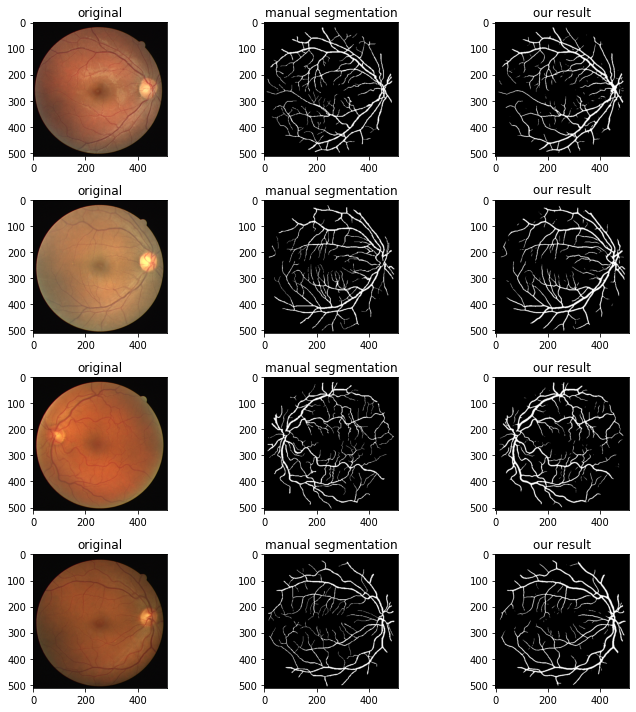

In [0]:
# load pretrained CNN

CNN = IterNet(drop = 0.1, iterations = 1).to(device)
CNN.load_state_dict(torch.load('VGN/models/CNN-pretrained/CNN.pt'))
CNN.eval()

train_loader = DataLoader(DriveDataset(root, mode='test'),
                         batch_size=1,
                         shuffle=False)


test_loader = DataLoader(DriveDataset(root, mode='test'),
                         batch_size=1,
                         shuffle=False)

def apply_threshold(output, threshold):
    x = torch.ones_like(output)
    y = torch.zeros_like(output)
    output = torch.where(output > threshold, x, y)
    return output


F1_scores = []
dice_scores = []

for i, batch in enumerate(test_loader):
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    CNN.eval()
    output = CNN(input) 
    probs = torch.sigmoid(output) 
    #apply threshold
    binary_img = apply_threshold(probs, threshold=0.5) * mask   


    y_true = label.view(-1).cpu()
    y_pred = binary_img.view(-1).cpu()
    F1_scores.append(f1_score(y_true,y_pred))

print("Training set, F1 score : ",np.mean(F1_scores))


### Validation
fig, axes = plt.subplots(len(test_loader), 3, figsize =(10,10))
subtitles = ['original', 'manual segmentation', 'our result']

CNN_only_binary_images = list()
F1_scores = []
dice_scores = []

for i, batch in enumerate(test_loader):
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    CNN.eval()
    output = CNN(input) 
    probs = torch.sigmoid(output) 
    #apply threshold
    binary_img = apply_threshold(probs, threshold=0.5) * mask   
    CNN_only_binary_images.append(binary_img)
    # display images 
    images = [input, label, binary_img]
    for j,IMG in enumerate(images):
        axes[i,j].imshow(trans(IMG.squeeze(0).cpu()).convert('RGB'))
        axes[i,j].set_title(subtitles[j])

    y_true = label.view(-1).cpu()
    y_pred = binary_img.view(-1).cpu()
    F1_scores.append(f1_score(y_true,y_pred))

fig.tight_layout()

print("Validation set, F1 score : ",np.mean(F1_scores))

# Area Under the Curve

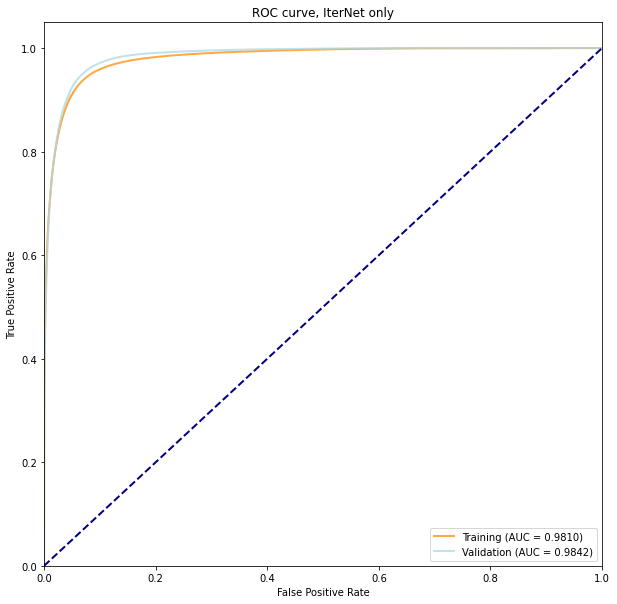

In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
root = 'VGN/data/training/'

### On training set
dataset = DriveDataset(root, mode='train')
cuda = True if next(CNN.parameters()).is_cuda else False
y_score = []
y_train = []

for i in range(len(dataset)):
    img = dataset[i]['input']
    if cuda:
        input = img.unsqueeze(0).cuda()
    else:
        input = img.unsqueeze(0)

    label = dataset[i]['label']
    mask = dataset[i]['mask']#.unsqueeze(0).cuda()
    
    output = CNN(input) 
    output = output[0,:,:,:].cpu()
    probs = torch.sigmoid(output) 

    #apply threshold
    probs = probs * mask
    
    y_train += list(label.detach().numpy().ravel())
    y_score += list(probs.detach().numpy().ravel())


fpr_train, tpr_train, _ = roc_curve(y_train, y_score, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)



### On validation set
dataset = DriveDataset(root, mode='test')
cuda = True if next(CNN.parameters()).is_cuda else False
y_score = []
y_test = []

for i in range(len(dataset)):
    img = dataset[i]['input']
    if cuda:
        input = img.unsqueeze(0).cuda()
    else:
        input = img.unsqueeze(0)

    label = dataset[i]['label']
    mask = dataset[i]['mask']#.unsqueeze(0).cuda()
    
    output = CNN(input) 
    output = output[0,:,:,:].cpu()
    probs = torch.sigmoid(output) 

    #apply threshold
    probs = probs * mask
    
    y_test += list(label.detach().numpy().ravel())
    y_score += list(probs.detach().numpy().ravel())


fpr_val, tpr_val, _ = roc_curve(y_test, y_score, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',alpha=0.75,
         lw=lw, label='Training (AUC = %0.4f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='lightblue', alpha=0.75,
         lw=lw, label='Validation (AUC = %0.4f)' % roc_auc_val)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, IterNet only')
plt.legend(loc="lower right")
plt.show()

# **Building the Graph**

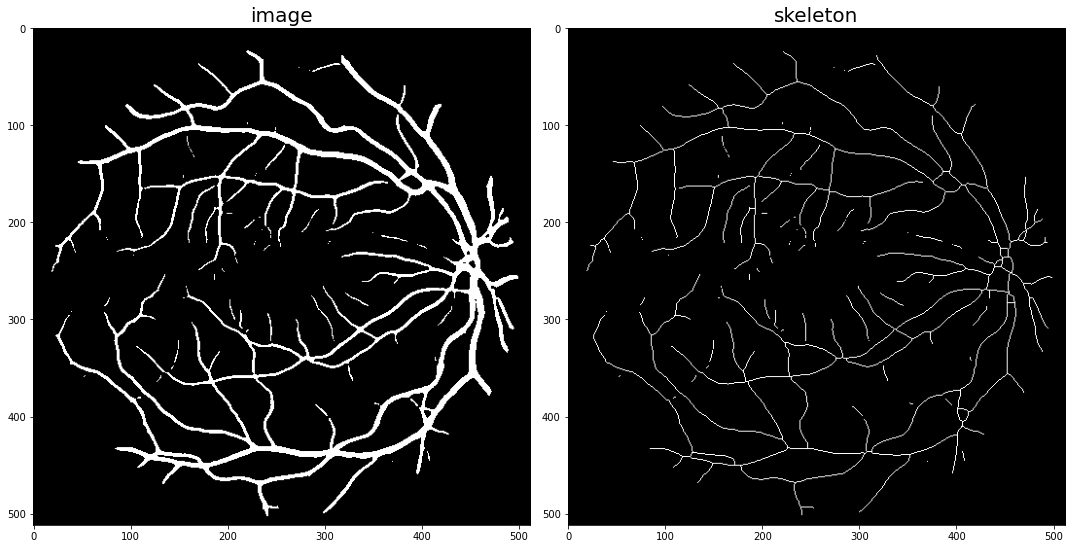

In [0]:
from skimage.morphology import skeletonize

trans = transforms.ToPILImage()
img = torch.squeeze(binary_img).cpu()

skeleton = torch.Tensor(skeletonize(np.array(img,dtype='uint8')))

subtitles = ['image', 'skeleton']
images = [img, skeleton]
fig, axes = plt.subplots(1, 2, figsize =(15,10))
for j in range(2):
    axes[j].imshow(trans(images[j]).convert('1'))
    axes[j].set_title(subtitles[j],fontsize=20)

fig.tight_layout()



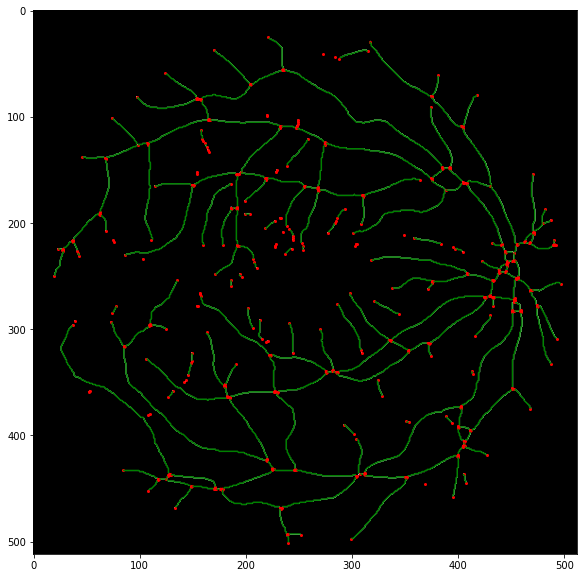

In [0]:
# build graph from skeleton
graph = sknw.build_sknw(skeleton)

plt.figure(figsize=(10,10))
#draw edges
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# display main nodes   
for n in graph.nodes():
    ps = graph.nodes[n]['pts']
    plt.scatter(ps[:,1], ps[:,0], color = 'red', marker='o',s=4)
    plt.plot(ps[:,1], ps[:,0], 'red')

plt.imshow(skeleton, cmap='gray')


In [0]:
def create_nx_graph(img,delta=5):
    '''
    img: a binary image (tensor of size 512 * 512)
    delta : sampling distance
    return : a networkx Graph
    '''

    # build graph from skeleton
    skeleton = skeletonize(np.array(img,dtype='uint8'))
    graph = sknw.build_sknw(skeleton)

    attrs = dict()
    # select only one point if a main node contains multiple points 
    for s in graph.nodes():
        ps = graph.nodes[s]['pts']
        attrs[s]= {'pts': np.array(ps[0],dtype=np.int64)}

    # add nodes between main nodes by equidistant sampling, with distance delta
    for (s,e) in list(graph.edges()):
        ps = graph[s][e]['pts']     
        for i, pt in enumerate(ps):
            if (i+1) % delta == 0:
                id_node = graph.number_of_nodes()
                graph.add_node(id_node)
                graph.add_edges_from([(s, id_node),(id_node, e)])
                attrs[id_node] = {'pts': np.array(pt,dtype=np.int64)}
    
    nx.set_node_attributes(graph, attrs)
    return graph

def nx_to_dgl(nxG):

    G = DGLGraph()
    G.from_networkx(nxG, node_attrs=['pts'])
    # add self loop
    G.add_edges(G.nodes(),G.nodes())
    
    #add edges of 2-hop neighbors for skeletal connectivity 
    U,V = [], []
    for node in G.nodes():
        node = torch.LongTensor([node])
        for n in G.predecessors(node):
            u = G.predecessors(n)
            v = torch.ones_like(G.predecessors(n))*node
            U.append(u)
            V.append(v)
    for i in range(len(U)):
        u,v = U[i], V[i]
        mask = (G.has_edges_between(u,v)==0)
        u = torch.masked_select(u,mask)
        v = torch.masked_select(v,mask)
        G.add_edges(u,v)
    
    return G


def build_dglGraph(img, delta=5):
    nxG = create_nx_graph(img, delta) 
    return nx_to_dgl(nxG)

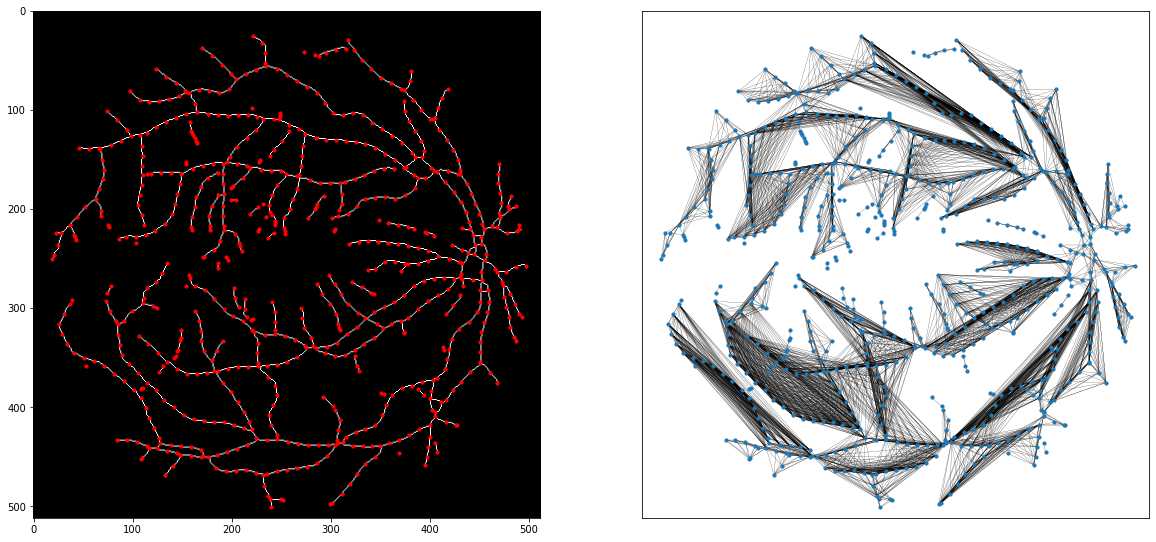

In [0]:
G = build_dglGraph(img, delta=10)

nxG = G.to_networkx(node_attrs=['pts'])
pos = dict()
# nodes position
for n in nxG.nodes():
    pos[n] = np.array(nxG.nodes[n]['pts'])
    pos[n][0], pos[n][1]= pos[n][1], pos[n][0]

# display graphs

fig, axes = plt.subplots(1, 2, figsize =(20,20))

for n in nxG.nodes():
    ps = nxG.nodes[n]['pts']
    axes[0].scatter(ps[1], ps[0], color = 'red', marker='o',s=10)
axes[0].imshow(skeleton, cmap='gray') 
nx.draw_networkx(nxG, pos=pos, arrows=False, with_labels=False, node_size=10,width=0.1)
axes[1].imshow(skeleton,alpha=0)


In [0]:
##############################
#      GAT
##############################

# parts of this code is borrowed from the full example at https://github.com/dmlc/dgl/blob/master/examples/pytorch/gat/gat.py
class GAT(nn.Module):
    def __init__(self,
                 num_layers=2,
                 in_dim=32,
                 num_hidden=16,
                 num_classes=1,
                 heads=[2,2],
                 activation=None,
                 feat_drop=0.5,
                 attn_drop=0.5,
                 negative_slope=0.2,
                 residual=False):
        
        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = activation
     
        # input projection (no residual)
        self.gat_layers.append(GATConv(
        in_dim, num_hidden, heads[0],
        feat_drop, attn_drop, negative_slope, False, activation))
        # hidden layers
        for l in range(1, num_layers-2):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, activation))
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_classes, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))

    def forward(self, graph, inputs):
        h = inputs
        #hidden layers
        for l in range(self.num_layers-2):
            h = self.gat_layers[l](graph, h).flatten(1)
            
        # output projection
        logits = self.gat_layers[-1](graph, h).mean(1)
        return logits


In [0]:
class VGN(nn.Module):
    def __init__(self):
        super(VGN, self).__init__()      
        self.conv1 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.dropout =  nn.Dropout(p=0.3)
    
    def forward(self, x, y):
        h = torch.cat((x, y), 1) # concat CCN and GCN features
        h = self.conv1(h)
        h = self.conv2(self.relu(h))
        h = self.conv3(self.relu(h))
        h = self.conv4(self.relu(h))
        h = self.conv5(self.relu(h))

        return h


In [0]:
class DriveDataset_and_Graphs(DriveDataset):
    """Dataset utility class.

    Parameters
    ----------
    root : str
        Path of the folder with all the images.
    
    CNN: a Convolutional neural network 

    mode : {'train' or 'test'} (default = 'train')
        Part of the dataset that is loaded. Use 'train' to get the training set
        and 'test' to get the test set.
    
    """
    def __init__(self, root, CNN, mode='train', delta=5, threshold=0.5): 

        self.root = root
        self.CNN = CNN
        self.CNN.eval()
        self.delta = delta
        self.threshold = threshold

        dataset = self.preprocess_image(root)
         
        inputs = [t[0] for t in dataset if t[1]=='input']
        masks = [t[0] for t in dataset if t[1]=='mask']
        labels = [t[0] for t in dataset if t[1]=='label']
        
        n = int(0.8 * len(inputs))
        
        if mode == 'train':   
            
            self.inputs = inputs[:n]
            self.masks = masks[:n]
            self.labels = labels[:n]

        elif mode == 'test':

            self.inputs = inputs[n:]
            self.masks = masks[n:]
            self.labels = labels[n:]
        
        self._construct_graphs()

    def _construct_graphs(self):

        graphs = list()
        for input, mask in zip(self.inputs, self.masks):
            input = input.to(device)
            mask = mask.to(device)
            output = self.CNN(input.unsqueeze(0)) * mask.unsqueeze(0)
            probs = torch.sigmoid(output)
            binary_img = apply_threshold(probs, self.threshold) * mask
            binary_img = torch.squeeze(binary_img)
            graph = build_dglGraph(binary_img.cpu(), self.delta)
            graphs.append(graph)
            

        self.graphs = graphs
    
    def __getitem__(self, index):
        
        t1 = self.inputs[index]
        t2 = self.masks[index]
        t3 = self.labels[index]
        g = self.graphs[index]
        
            
        return {"input": t1, "mask": t2, "label":t3, "graph": g }



In [0]:
def default_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)


def collate_fn(batch):
    elem = batch[0]
    return {key : default_collate([d[key] for d in batch]) if key!='graph' else [d[key] for d in batch] for key in elem }




# **Training VGN**

In [0]:
# load pretrained CNN

CNN = IterNet(drop = 0.1, iterations = 1).to(device)
CNN.load_state_dict(torch.load('VGN/models/CNN-pretrained/CNN.pt'))

# register forward hook to access CNN last layer features

CNN_last_layer_input = []
GNN_last_layer_input = []

def getInput_CNN(self, input, output):
    if len(CNN_last_layer_input) >= 2: # keep only two last values in memory
        CNN_last_layer_input.pop(0)
    CNN_last_layer_input.append(input)

handle_CNN = CNN.final.model[0].register_forward_hook(getInput_CNN)



def train_VGN( CNN, root='VGN/data/training', num_epoch=200, batch_size=2, lr=0.0001, patiente=10, K_gc=5, delta=5, threshold=0.4):
    """
    Method used to train our VGN model
    
    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the training dataset
        CNN : pretrained CNN
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        K_gc: number of epochs between graph construction

    Returns:
        Classifier: (nn.Module) the trained VGN 
    """

    # Output folder 
    if not os.path.exists("VGN/models"):
        os.makedirs("VGN/models")
    for model in ['CNN', 'GNN', 'GVN']:
        if not os.path.exists("VGN/models/" + model):
            os.makedirs("VGN/models/" + model)
        

     
    # Loss functions
    criterion_CNN = torch.nn.BCEWithLogitsLoss() # pixelwise cross entropy 
    criterion_GNN = torch.nn.BCEWithLogitsLoss() # vertexwise cross entropy
    
    # initialize inference module and GNN 
    GNN = GAT().to(device)
    GVN = VGN().to(device)
    CNN = CNN.to(device)

    # register forward hook to access GNN last layer features
    
    def getInput_GNN(self, input, output):
        if len(GNN_last_layer_input) >= 2: # keep only the two last values in memory
            GNN_last_layer_input.pop(0)
        GNN_last_layer_input.append(input[1])

    handle_GNN = GNN.gat_layers[-1].register_forward_hook(getInput_GNN)


    # Optimizers CNN & GVN
   
    optimizer_CNN = torch.optim.Adam(CNN.parameters(), lr=lr)
    optimizer_GNN = torch.optim.Adam(GNN.parameters(), lr=lr)
    optimizer_GVN = torch.optim.Adam(GVN.parameters(), lr=lr)
   
    # Parameters for the LR of Adam optimizer
    scheduler_CNN = lr_scheduler.StepLR(optimizer_CNN,step_size=1,gamma=0.95)
    scheduler_GNN = lr_scheduler.StepLR(optimizer_GNN,step_size=1,gamma=0.95)
    scheduler_GVN = lr_scheduler.StepLR(optimizer_GVN,step_size=30,gamma=0.1)

    prev_time = time.time()
    test_best_loss = np.inf
    patiente_count = 0

    # ---------------------------
    #  Training & Testing jointly
    # ---------------------------

    for epoch in range(num_epoch):
        
        epoch_train_loss, epoch_train_loss_CNN, epoch_train_loss_GNN, epoch_train_loss_GVN = [], [], [], []
        epoch_test_loss, epoch_test_loss_CNN, epoch_test_loss_GNN, epoch_test_loss_GVN = [], [], [], []

        # new loaders every K_gc steps (graphs update)
        if epoch % K_gc == 0:
            train_loader = DataLoader(
                DriveDataset_and_Graphs(root, CNN, mode='train', delta=delta, threshold=threshold),
                batch_size=batch_size,
                shuffle=True,
                collate_fn=collate_fn)
            
            test_loader = DataLoader(
                DriveDataset_and_Graphs(root, CNN, mode='test', delta=delta, threshold=threshold),
                batch_size=batch_size,
                shuffle=False,
                collate_fn=collate_fn)
                                                             
        for loader in [train_loader, test_loader]:
            
            for i, batch in enumerate(loader):

                if loader == train_loader:
                    CNN.train()
                    GNN.train()
                    GVN.train()

                else: 
                    CNN.eval()
                    GNN.eval()
                    GVN.eval()
                
                # Inputs & masks & labels
                mask = batch['mask'].to(device)
                input = batch['input'].to(device)
                label = batch['label'].to(device)   
                graphs = batch['graph']

                # ------------------
                #  CNN
                # ------------------
                output = CNN(input) * mask
                loss_CNN = criterion_CNN(output, label)
                # ------------------
                #  GCN
                # ------------------
                loss_GNN = 0 
                CNN_features = CNN_last_layer_input[-1][0]
                GNN_features = torch.zeros_like(CNN_features)
    
                weight = torch.ones_like(label)
                for i, g in enumerate(graphs):
                    g.to(device)
                    feat = CNN_features[i]
                    feat = feat[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0)
                    label_i = label[i]
                    label_i = label_i[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0).unsqueeze(0)
                    output_i = GNN(g,feat).unsqueeze(0)
                    loss_GNN += criterion_GNN(output_i, label_i)
                    GNN_features[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = GNN_last_layer_input[-1].permute(1,0)
                    weight[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = delta**2
                
                loss_GNN = loss_GNN / len(graphs)

                # ------------------
                #  VGN
                # ------------------
                output_GVN = GVN(CNN_features, GNN_features) * mask
                criterion_GVN = torch.nn.BCEWithLogitsLoss(weight=weight)
                
                loss_GVN = criterion_GVN(output_GVN, label)

                # total loss
                loss = loss_CNN + loss_GNN + loss_GVN

                # ------------------
                #  Train
                # ------------------

                if loader == train_loader:
                    
                    optimizer_CNN.zero_grad()
                    loss.backward(retain_graph=True)
                    optimizer_CNN.step()

                    optimizer_GNN.zero_grad()
                    loss_GNN.backward(retain_graph=True)
                    optimizer_GNN.step()
                    
                    
                    optimizer_GVN.zero_grad()
                    loss_GVN.backward()
                    optimizer_GVN.step()
                    
                    epoch_train_loss.append(loss.item())
                    epoch_train_loss_CNN.append(loss_CNN.item())
                    epoch_train_loss_GNN.append(loss_GNN.item())
                    epoch_train_loss_GVN.append(loss_GVN.item())

                
                # ------------------
                #  Test
                # ------------------
                
                elif loader == test_loader:
                    epoch_test_loss.append(loss.item())
                    epoch_test_loss_CNN.append(loss_CNN.item())
                    epoch_test_loss_GNN.append(loss_GNN.item())
                    epoch_test_loss_GVN.append(loss_GVN.item())

        
        if not np.mean(epoch_test_loss) < test_best_loss - 1e-3:
            patiente_count += 1

        else:
            patiente_count = 0
            test_best_loss = np.mean(epoch_test_loss)
            best_model_CNN = copy(CNN)
            best_model_GNN = deepcopy(GNN)
            best_model_GVN = deepcopy(GVN)
            torch.save(CNN.state_dict(), 'VGN/models/CNN/CNN.pt')
            torch.save(GNN.state_dict(), 'VGN/models/GNN/GNN.pt')
            torch.save(GVN.state_dict(), 'VGN/models/GVN/GVN.pt')

        if patiente_count >= patiente:
            
            sys.stdout.write('\ntest loss did not decrease for %d consecutive epochs' % (patiente))
            break
    

        # --------------
        #  Log Progress
        # --------------
        
        # Determine approximate time left
        
        epochs_left = num_epoch - epoch + 1
        time_left = datetime.timedelta(seconds=epochs_left * (time.time() - prev_time))
        prev_time = time.time()
                        
        
        sys.stdout.write(
            "\r[Epoch %d/%d]  [TRAIN Loss: %f / CNN: %f / GNN: %f / inference: %f] [TEST Loss: %f / CNN: %f / GNN: %f / inference: %f] ETA: %s"
            % (
                epoch,
                num_epoch,
                np.mean(epoch_train_loss),
                np.mean(epoch_train_loss_CNN),
                np.mean(epoch_train_loss_GNN),
                np.mean(epoch_train_loss_GVN),
                np.mean(epoch_test_loss),
                np.mean(epoch_test_loss_CNN),
                np.mean(epoch_test_loss_GNN),
                np.mean(epoch_test_loss_GVN),
                time_left
            )
        )            
        if epoch % 10 == 0:                
            # Save models every 10 epochs
            torch.save(CNN.state_dict(), 'VGN/models/CNN/CNN-epoch-%s.pt' % epoch)
            torch.save(GNN.state_dict(), 'VGN/models/GNN/GNN-epoch-%s.pt' % epoch)
            torch.save(GVN.state_dict(), 'VGN/models/GVN/GVN-epoch-%s.pt' % epoch)
    
        # decrease lr 
        scheduler_CNN.step()
        #scheduler_GVN.step()
        #scheduler_GNN.step()

    return best_model_CNN, best_model_GNN, best_model_GVN

CNN, GNN, GVN = train_VGN(CNN, num_epoch=200, batch_size=1, lr=0.0005, patiente=20, K_gc=20, delta=5, threshold=0.3)

[Epoch 52/200]  [TRAIN Loss: 1.024425 / CNN: 0.288579 / GNN: 0.405323 / inference: 0.330523] [TEST Loss: 1.050279 / CNN: 0.288931 / GNN: 0.428761 / inference: 0.332586] ETA: 0:12:45.541646
test loss did not decrease for 20 consecutive epochs

In [0]:
# load CNN , GNN,  GVN  

CNN = IterNet(drop = 0.1, iterations = 1).to(device)
GNN = GAT().to(device)
GVN = VGN().to(device)

CNN.load_state_dict(torch.load('VGN/models/CNN/CNN.pt'))
GNN.load_state_dict(torch.load('VGN/models/GNN/GNN.pt'))
GVN.load_state_dict(torch.load('VGN/models/GVN/GVN.pt'))

CNN.eval()
GNN.eval()
GVN.eval()

# register forward hook to access CNN last layer features

CNN_last_layer_input = []

def getInput_CNN(self, input, output):
    if len(CNN_last_layer_input) >= 2: # keep only two last values in memory
        CNN_last_layer_input.pop(0)
    CNN_last_layer_input.append(input)

handle_CNN = CNN.final.model[0].register_forward_hook(getInput_CNN)

# register forward hook to access GNN last layer features
    
GNN_last_layer_input = []
def getInput_GNN(self, input, output):
    if len(GNN_last_layer_input) >= 2: # keep only the two last values in memory
        GNN_last_layer_input.pop(0)
    GNN_last_layer_input.append(input[1])

handle_GNN = GNN.gat_layers[-1].register_forward_hook(getInput_GNN)


In [0]:
train_loader = DataLoader(
                DriveDataset_and_Graphs(root, CNN, mode='train', delta=5, threshold=0.3),
                batch_size=1,
                shuffle=False,
                collate_fn=collate_fn)

test_loader = DataLoader(
                DriveDataset_and_Graphs(root, CNN, mode='test', delta=5, threshold=0.3),
                batch_size=1,
                shuffle=False,
                collate_fn=collate_fn)

# Vizualization of our VGN on test set 

Training, F1 score :  0.8061933472553047
Validation, F1 score :  0.7961863295686449


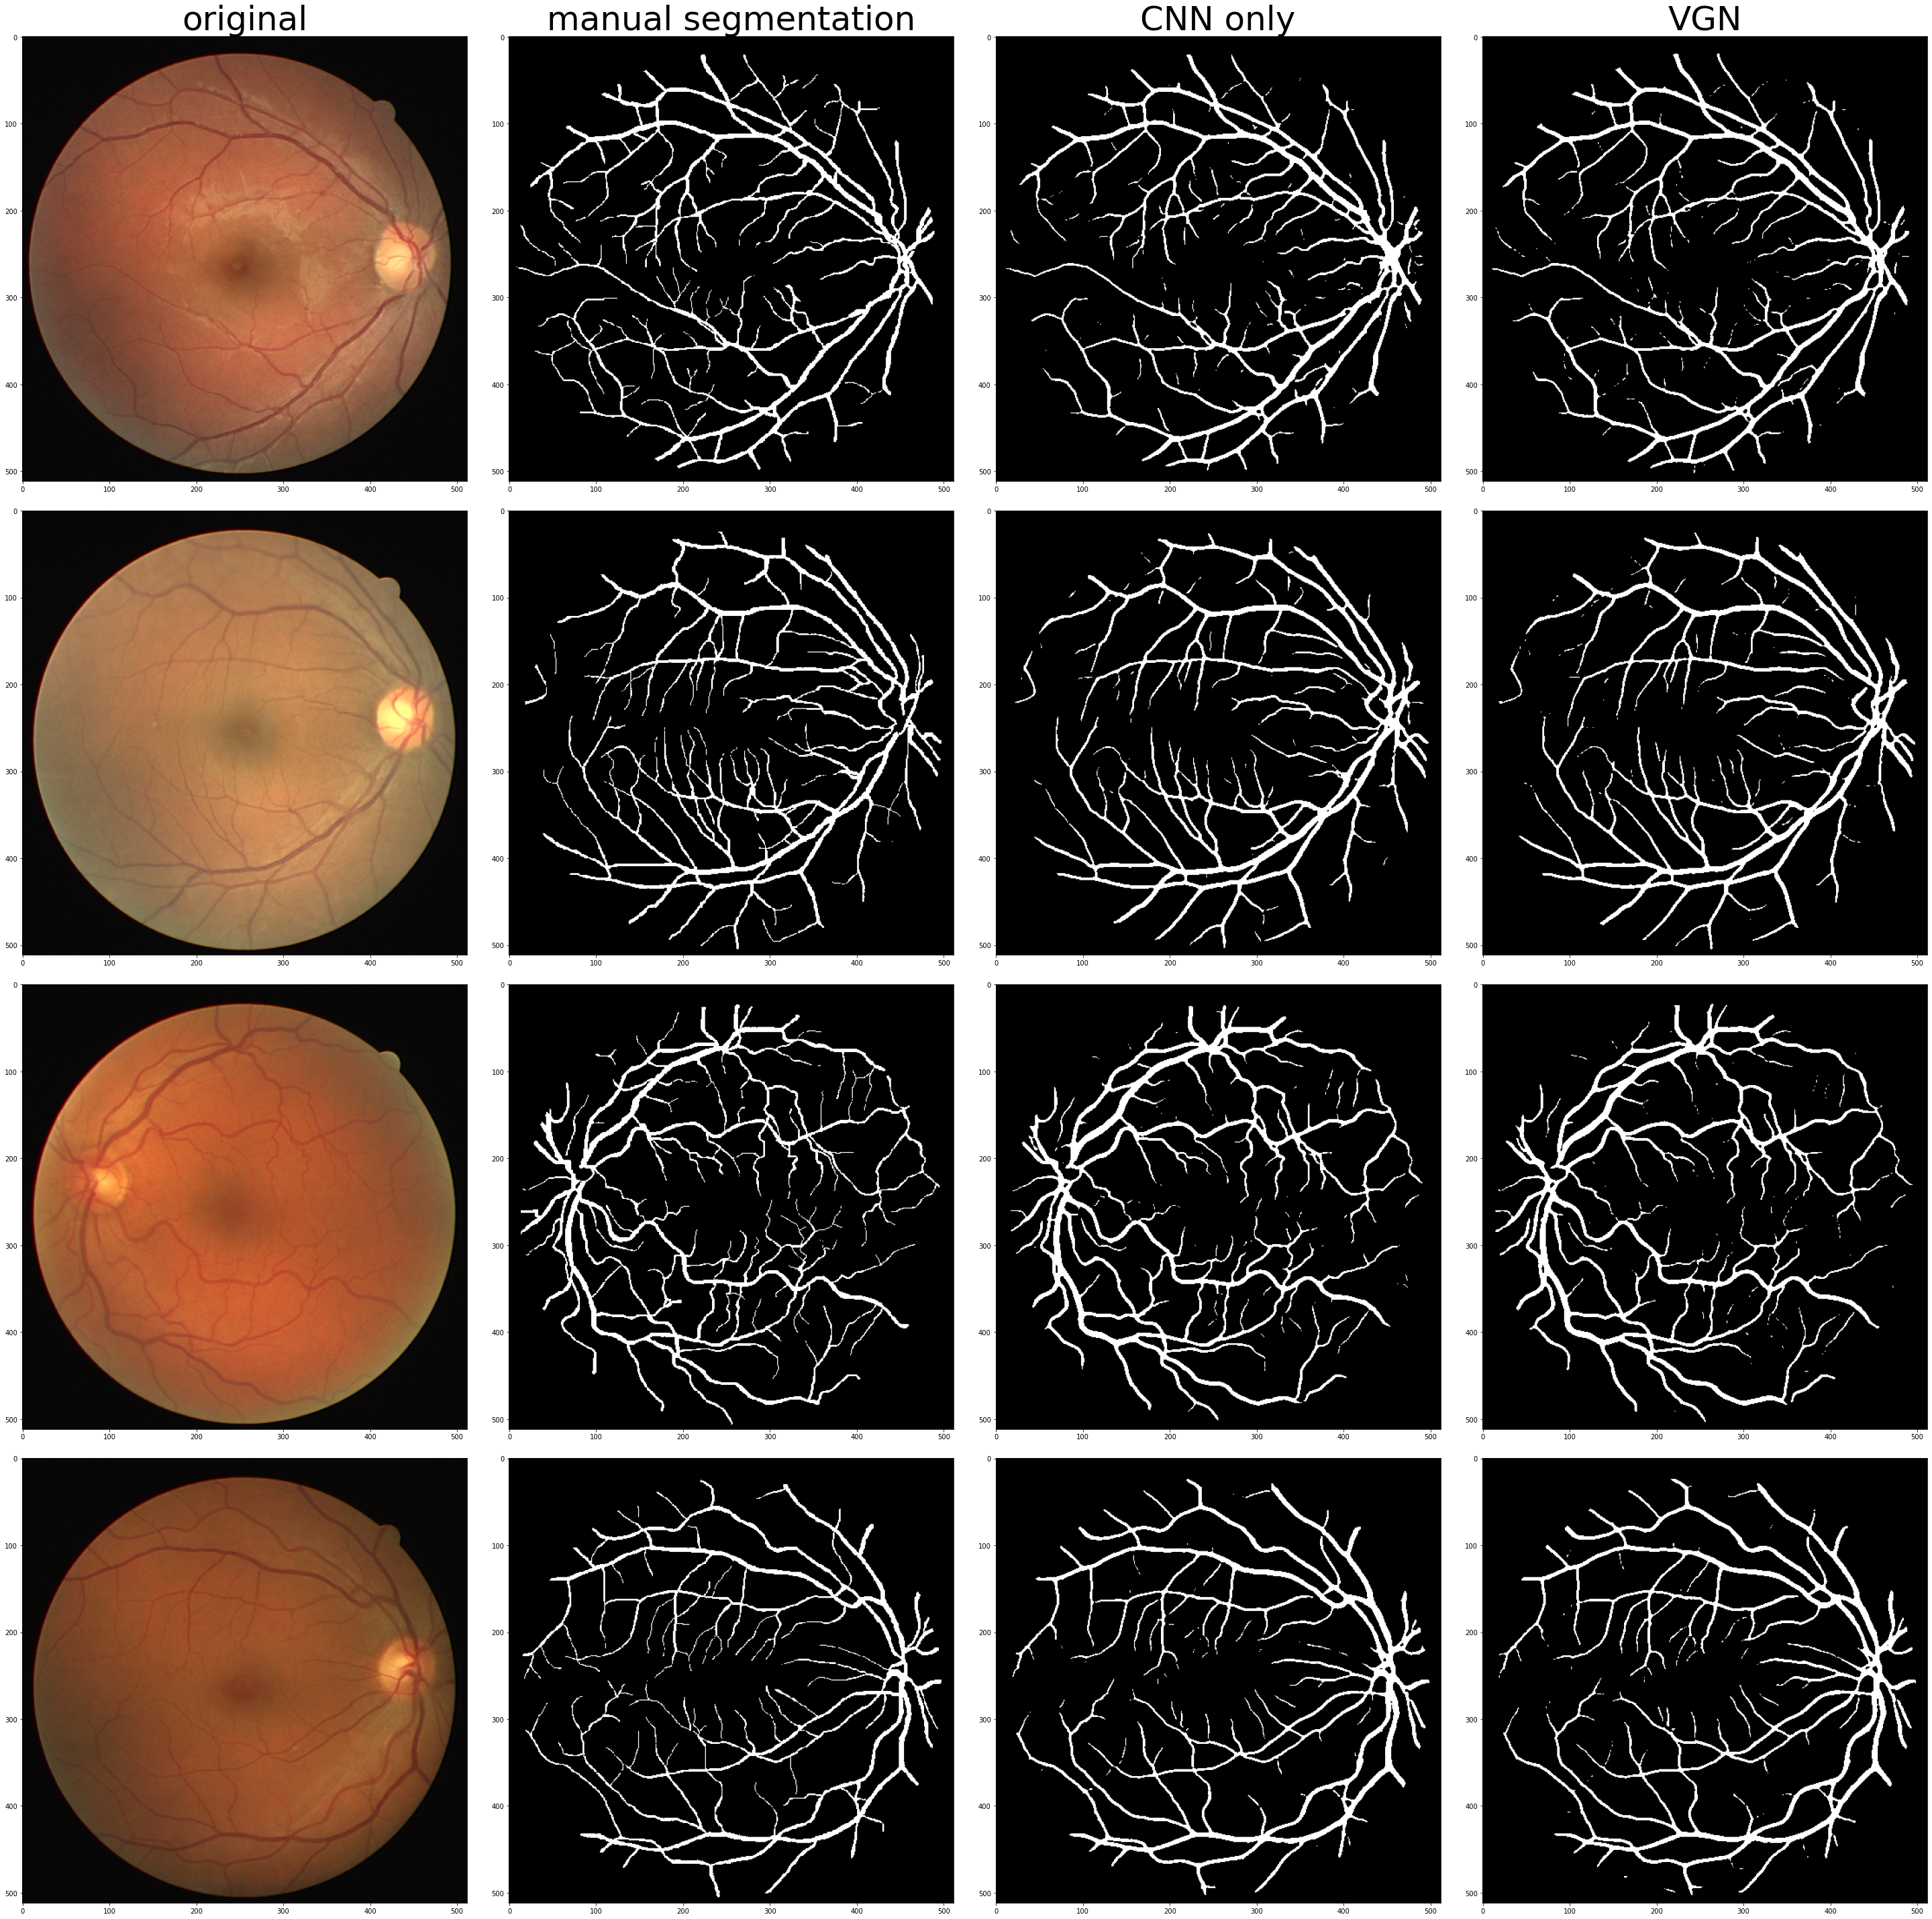

In [0]:
delta = 5
threshold = 0.5


# On training set
F1_scores = []
dice_scores = []

for k, batch in enumerate(train_loader):
    
    # Inputs & masks & labels
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    graphs = batch['graph']

    # ------------------
    #  CNN
    # ------------------
    output = CNN(input) 
    
    CNN_features = CNN_last_layer_input[-1][0] 
    # ------------------
    #  GCN
    # ------------------
    
    GNN_features = torch.zeros_like(CNN_features)

    weight = torch.ones_like(label)
    for i, g in enumerate(graphs):
       
        feat = CNN_features[i]
        feat = feat[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0)
        label_i = label[i]
        label_i = label_i[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0).unsqueeze(0)
        output_i = GNN(g,feat).unsqueeze(0)
        GNN_features[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = GNN_last_layer_input[-1].permute(1,0)
        weight[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = delta**2


    # ------------------
    #  VGN
    # ------------------
    output_GVN = GVN(CNN_features, GNN_features)  
    criterion_GVN = torch.nn.BCELoss()#weight=weight)
                
    probs = torch.sigmoid(output_GVN)* mask
    loss_GVN = criterion_GVN(probs, label)
    binary_img = apply_threshold(probs,threshold) * mask  

    y_true = label.view(-1).cpu()
    y_pred = binary_img.view(-1).cpu()
    F1_scores.append(f1_score(y_true,y_pred))

print("Training, F1 score : ",np.mean(F1_scores))



### On validation set

fig, axes = plt.subplots(len(test_loader), 4, figsize =(40,40))
subtitles = ['original','manual segmentation' ,'CNN only', 'VGN']

F1_scores = []
dice_scores = []

for k, batch in enumerate(test_loader):
    
    # Inputs & masks & labels
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    graphs = batch['graph']

    # ------------------
    #  CNN
    # ------------------
    output = CNN(input) 
    
    CNN_features = CNN_last_layer_input[-1][0] 
    # ------------------
    #  GCN
    # ------------------
    
    GNN_features = torch.zeros_like(CNN_features)

    weight = torch.ones_like(label)
    for i, g in enumerate(graphs):
       
        feat = CNN_features[i]
        feat = feat[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0)
        label_i = label[i]
        label_i = label_i[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0).unsqueeze(0)
        output_i = GNN(g,feat).unsqueeze(0)
        GNN_features[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = GNN_last_layer_input[-1].permute(1,0)
        weight[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = delta**2


    # ------------------
    #  VGN
    # ------------------
    output_GVN = GVN(CNN_features, GNN_features)  
    criterion_GVN = torch.nn.BCELoss()#weight=weight)
                
    probs = torch.sigmoid(output_GVN)* mask
    loss_GVN = criterion_GVN(probs, label)
    binary_img = apply_threshold(probs,threshold) * mask  
    
    # display images 
    images = [input, label, CNN_only_binary_images[k], binary_img]
    for j,IMG in enumerate(images):
        axes[k,j].imshow(trans(IMG.squeeze(0).cpu()).convert('RGB'))
        axes[i,j].set_title(subtitles[j],fontsize=50)

    y_true = label.view(-1).cpu()
    y_pred = binary_img.view(-1).cpu()
    F1_scores.append(f1_score(y_true,y_pred))
    dice_scores.append(dice(y_pred, y_true))

print("Validation, F1 score : ",np.mean(F1_scores))

fig.tight_layout()
plt.show()



In [0]:
import gc
gc.collect()

torch.cuda.empty_cache()

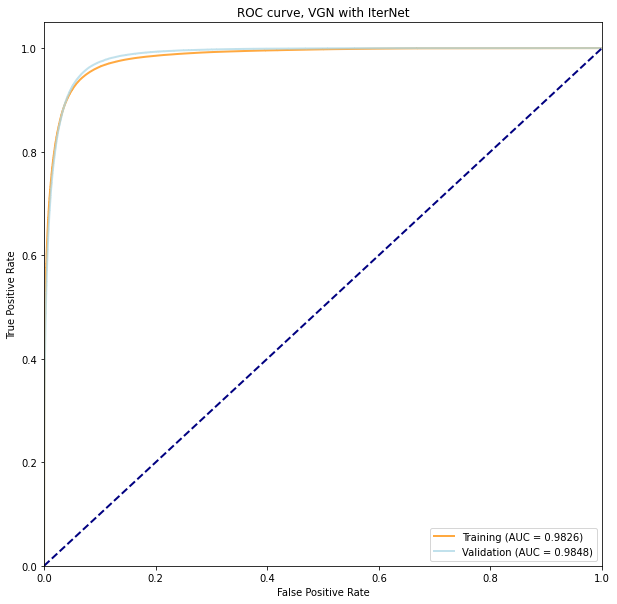

In [0]:


cuda = True if next(CNN.parameters()).is_cuda else False
### On training

y_score = []
y_train = []

for k, batch in enumerate(train_loader):
    # Inputs & masks & labels
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    graphs = batch['graph']


    # ------------------
    #  CNN
    # ------------------
    output = CNN(input) 
    
    CNN_features = CNN_last_layer_input[-1][0] 
    # ------------------
    #  GCN
    # ------------------
    
    GNN_features = torch.zeros_like(CNN_features)

    weight = torch.ones_like(label)
    for i, g in enumerate(graphs):
       
        feat = CNN_features[i]
        feat = feat[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0)
        label_i = label[i]
        label_i = label_i[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0).unsqueeze(0)
        output_i = GNN(g,feat).unsqueeze(0)
        GNN_features[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = GNN_last_layer_input[-1].permute(1,0)
        weight[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = delta**2


    # ------------------
    #  VGN
    # ------------------
    output_GVN = GVN(CNN_features, GNN_features)  
    criterion_GVN = torch.nn.BCELoss()#weight=weight)
                
    probs = torch.sigmoid(output_GVN)* mask

    #apply threshold
    probs = probs * mask
    
    y_train += list(label.detach().cpu().numpy().ravel())
    y_score += list(probs.detach().cpu().numpy().ravel())

fpr_train, tpr_train, _ = roc_curve(y_train, y_score, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)


### On validation
y_score = []
y_test = []

for k, batch in enumerate(test_loader):
    # Inputs & masks & labels
    mask = batch['mask'].to(device)
    input = batch['input'].to(device)
    label = batch['label'].to(device)   
    graphs = batch['graph']

    # ------------------
    #  CNN
    # ------------------
    output = CNN(input) 
    
    CNN_features = CNN_last_layer_input[-1][0] 
    # ------------------
    #  GCN
    # ------------------
    
    GNN_features = torch.zeros_like(CNN_features)

    weight = torch.ones_like(label)
    for i, g in enumerate(graphs):
       
        feat = CNN_features[i]
        feat = feat[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0)
        label_i = label[i]
        label_i = label_i[:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]].permute(1,0).unsqueeze(0)
        output_i = GNN(g,feat).unsqueeze(0)
        GNN_features[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = GNN_last_layer_input[-1].permute(1,0)
        weight[i,:,g.ndata['pts'][:,0],g.ndata['pts'][:,1]] = delta**2


    # ------------------
    #  VGN
    # ------------------
    output_GVN = GVN(CNN_features, GNN_features)  
    criterion_GVN = torch.nn.BCELoss()#weight=weight)
                
    probs = torch.sigmoid(output_GVN)* mask

    #apply threshold
    probs = probs * mask
    
    y_test += list(label.detach().cpu().numpy().ravel())
    y_score += list(probs.detach().cpu().numpy().ravel())

fpr_val, tpr_val, _ = roc_curve(y_test, y_score, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)


plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',alpha=0.75,
         lw=lw, label='Training (AUC = %0.4f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='lightblue', alpha=0.75,
         lw=lw, label='Validation (AUC = %0.4f)' % roc_auc_val)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, VGN with IterNet')
plt.legend(loc="lower right")
plt.show()